In [288]:
import pandas as pd
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self,path, p_lag=0, d_lag=0, test=False):
        self.df = pd.read_csv(path)
        if test: 
            self.df = self.df.iloc[round(len(self.df)*0.8):len(self.df),:]
        else: 
            self.df = self.df.iloc[0:round(len(self.df)*0.8),:]
        self.p_lag = p_lag
        self.d_lag = d_lag
        self.len_df_minus_lag = len(self.df) - p_lag - d_lag
        
    def __len__(self):
        return self.len_df_minus_lag

    def __getitem__(self, idx):
        input_p_lag = torch.tensor(self.df.iloc[(idx+self.d_lag):(idx+self.d_lag + self.p_lag),1].astype(float).values, requires_grad=True)
        if self.d_lag >0: 
            input_d_lag = torch.tensor(self.df.iloc[idx:(idx + self.p_lag),1].astype(float).values)
            input = input_p_lag - input_d_lag
        else: 
            input = input_p_lag
        target = torch.tensor(self.df.iloc[(idx + self.p_lag + 1),1].astype(float))
        return input, target

In [275]:
import math
import torch.nn as nn

class ARNet(nn.Module):
    def __init__(self, p_lag):
        super(ARNet, self).__init__()
        self.input_layer = nn.Linear(p_lag, math.ceil(p_lag/2))
        self.output_layer = nn.Linear(math.ceil(p_lag/2), 1)
        self.criterion = nn.MSELoss()

    def forward(self, input):
        input = input.float()
        y_hat = self.input_layer(input)
        return torch.exp(self.output_layer(y_hat))

In [289]:
p_lag = 36

net = ARNet(p_lag)

train_data = TimeSeriesDataset(path='Electric_Production.csv',p_lag=p_lag,d_lag=0,test=False)
train_loss_list = []
test_data = TimeSeriesDataset(path='Electric_Production.csv',p_lag=p_lag,d_lag=0,test=True)
test_loss_list = []

torch.set_grad_enabled(True)
optimizer = torch.optim.SGD(net.parameters(), lr=0.000001, momentum=0.9)
running_train_loss = 0.
running_test_loss = 0.
train_counter = 1
test_counter = 1
for epoch in range(2000): 
    for i, data in enumerate(train_data):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(torch.log(inputs))
        loss = torch.sqrt(net.criterion(outputs, labels.unsqueeze(0).float()))
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        train_counter += 1
    train_loss_list.append(running_train_loss/train_counter)

    for i, data in enumerate(test_data):
        inputs, test_labels = data
        output = net(torch.log(inputs))
        test_loss = torch.sqrt(net.criterion(output, test_labels.unsqueeze(0).float()))
        running_test_loss += test_loss.item()
        test_counter += 1
    test_loss_list.append(running_test_loss/test_counter)

    if epoch % 25 == 0: 
        print(f"Epoch {epoch}: ")
        print(f"Running (training) loss is {running_train_loss/train_counter}.")
        print(f"Test loss is {running_test_loss/test_counter}.")
        print("---------------------------")

for i, data in enumerate(test_data):
    inputs, labels = data
    output = net(torch.log(inputs))
    print(f"predicted output is {output.item()} and true value is {labels.item()}")


Epoch 0: 
Running (training) loss is 67.01343844799285.
Test loss is 8.368063106093295.
---------------------------
Epoch 25: 
Running (training) loss is 10.478582397602938.
Test loss is 8.520829154500586.
---------------------------
Epoch 50: 
Running (training) loss is 8.581697523610538.
Test loss is 7.505781881285226.
---------------------------
Epoch 75: 
Running (training) loss is 7.734592076404413.
Test loss is 7.637288725267859.
---------------------------
Epoch 100: 
Running (training) loss is 7.258350006193836.
Test loss is 7.43643518250533.
---------------------------
Epoch 125: 
Running (training) loss is 6.907815116515798.
Test loss is 6.94006755143466.
---------------------------
Epoch 150: 
Running (training) loss is 6.690620330663828.
Test loss is 6.869854348043754.
---------------------------
Epoch 175: 
Running (training) loss is 6.512971234581431.
Test loss is 6.758680174625824.
---------------------------


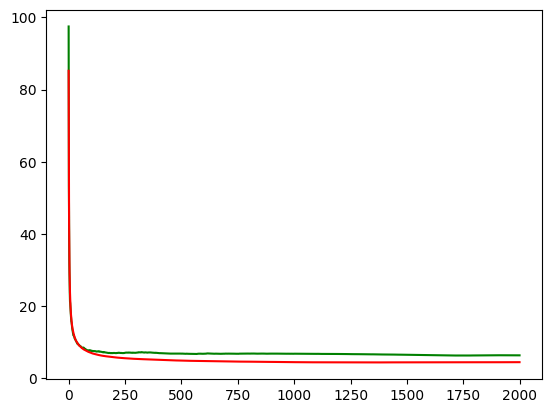

In [ ]:
import matplotlib.pyplot as plt
plt.plot(test_loss_list, 'g', train_loss_list, 'r')
plt.show()